## LSTM Auto-Encoder-Decoder for Anomaly Detection
From (https://gist.github.com/philipperemy/b8a7b7be344e447e7ee6625fe2fdd765)

In [165]:
import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
np.random.seed(23)

In [167]:
window_length = 10
sample_size = 100

In [168]:
signal_train = np.random.normal(loc=0, scale=1, size=(sample_size, 1))

In [169]:
signal_train.shape

(100, 1)

In [170]:
signal_train[:10]

array([[ 0.66698806],
       [ 0.02581308],
       [-0.77761941],
       [ 0.94863382],
       [ 0.70167179],
       [-1.05108156],
       [-0.36754812],
       [-1.13745969],
       [-1.32214752],
       [ 1.77225828]])

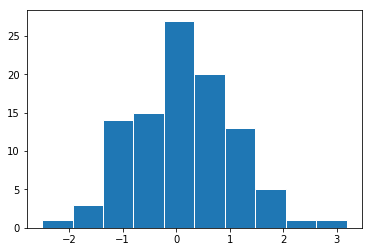

In [171]:
plt.hist(signal_train, bins=10, edgecolor='white');

In [172]:
#signal_train = np.expand_dims(signal_train, axis=1)

In [173]:
#signal_train.shape

**Generate training data, no outliers:**

In [174]:
full_train_sequence = signal_train.flatten()

In [175]:
full_train_sequence

array([ 0.66698806,  0.02581308, -0.77761941,  0.94863382,  0.70167179,
       -1.05108156, -0.36754812, -1.13745969, -1.32214752,  1.77225828,
       -0.34745899,  0.67014016,  0.32227152,  0.06034293, -1.04345   ,
       -1.00994188,  0.44173637,  1.12887685, -1.83806777, -0.93876863,
       -0.20184052,  1.04537128,  0.53816197,  0.81211867,  0.2411063 ,
       -0.95250953, -0.13626676,  1.26724821,  0.17363364, -1.22325477,
        1.41531998,  0.45771098,  0.72887584,  1.96843473, -0.54778801,
       -0.67941827, -2.50623032,  0.14696049,  0.60619549, -0.02253889,
        0.01342226,  0.93594489,  0.42062266,  0.41161964, -0.07132392,
       -0.04543758,  1.04088597, -0.09403473, -0.42084395, -0.55198856,
       -0.12109755,  0.19014136,  0.51213739,  0.13153847, -0.33161712,
       -1.63238628,  0.61911407, -0.99257378, -0.16134639,  1.19240433,
        0.25073655, -0.81361625,  0.70362363, -0.26814214, -0.48255948,
        1.24461048,  0.67686012,  3.18750269, -1.08056475,  0.01

**Prepare Sequences: Create windows of 10 data points each**

In [176]:
train_windows = []

In [177]:
for window_start in range(0, len(full_train_sequence) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(full_train_sequence[window_range])
    train_windows.append(window)

In [178]:
len(train_windows)

91

In [179]:
print(train_windows[0])

[0.66698805635346836, 0.025813081066273821, -0.77761941319181782, 0.9486338224949431, 0.70167179464751295, -1.0510815639071178, -0.36754811611716609, -1.1374596907250272, -1.3221475225908594, 1.7722582783074305]


In [180]:
print(train_windows[7])

[-1.1374596907250272, -1.3221475225908594, 1.7722582783074305, -0.34745899102186334, 0.67014016289715139, 0.32227152034930512, 0.060342934170488124, -1.0434500017467254, -1.0099418765878465, 0.44173637238220625]


In [181]:
np.array(train_windows).shape

(91, 10)

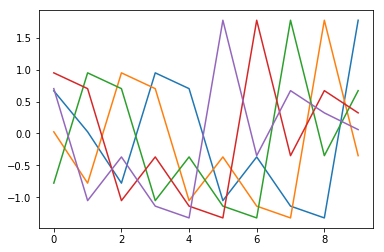

In [182]:
for window in train_windows[0:5]:
    plt.plot(window);

**Need to expand dimensions [samples, sequence_length, features]**

91 samples of 10 sequence_length each and since each point is univariate so feature size = 1

In [183]:
x_train = np.expand_dims(np.array(train_windows), axis=2)
x_train.shape

(91, 10, 1)

In [184]:
x_train[1:2]

array([[[ 0.02581308],
        [-0.77761941],
        [ 0.94863382],
        [ 0.70167179],
        [-1.05108156],
        [-0.36754812],
        [-1.13745969],
        [-1.32214752],
        [ 1.77225828],
        [-0.34745899]]])

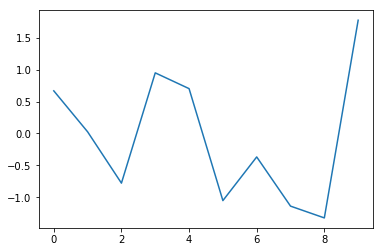

In [185]:
plt.plot(train_windows[0]);

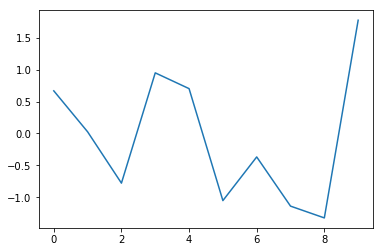

In [186]:
plt.plot(x_train[0].flatten());

**Generate testing data, with outliers:**

In [187]:
signal_test = np.random.normal(loc=0, scale=1, size=(sample_size, 1))

In [188]:
signal_test.shape

(100, 1)

In [189]:
outliers_size=0.01

In [190]:
random_indices = []
if outliers_size < 1:  # percentage.
    outliers_size = int(sample_size * outliers_size)
random_indices = np.random.choice(range(sample_size), size=outliers_size, replace=False)

In [191]:
random_indices

array([27])

In [192]:
signal_test[random_indices]

array([[-0.50145597]])

In [193]:
signal_test[random_indices] = np.random.randint(6, 9, 1)[0]

In [194]:
signal_test[random_indices]

array([[ 6.]])

In [195]:
full_test_sequence = signal_test.flatten()

In [196]:
full_test_sequence

array([ -1.33286349e+00,   1.63739122e+00,  -8.22938678e-01,
        -1.59810911e+00,   2.26511740e-01,   2.33897991e-01,
        -9.47222447e-01,  -1.26157621e+00,  -2.38986578e+00,
        -3.33273986e-01,   3.43516763e-01,  -2.02786082e+00,
         1.31416305e-01,   1.60323411e+00,  -1.76431364e+00,
         5.66503925e-01,   5.48788074e-01,  -6.15134980e-01,
         3.23545639e-01,  -1.10319346e+00,   4.50595963e-01,
         1.61745203e+00,  -3.42364941e-01,  -6.23486382e-01,
        -2.01480815e+00,   1.87089397e+00,   1.87319810e+00,
         6.00000000e+00,   9.00939436e-02,  -9.39445812e-02,
         1.36048482e+00,  -1.56984254e+00,   6.76403155e-01,
        -2.25588661e+00,   6.53615988e-01,  -7.45812797e-01,
         1.30678324e+00,   5.49310083e-01,  -6.12180617e-01,
        -7.36842113e-01,  -1.19535974e+00,   1.68204548e+00,
         1.06542280e+00,  -6.05563604e-01,  -1.33355413e+00,
         4.96057738e-01,   1.31938143e-02,  -4.85210052e-01,
         1.15830877e-01,

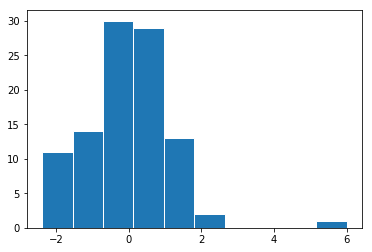

In [197]:
plt.hist(signal_test, bins=10, edgecolor='white');

In [198]:
test_windows = []
contain_outliers= []

In [199]:
for window_start in range(0, len(full_test_sequence) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(full_test_sequence[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [200]:
outlier_indices = np.where(contain_outliers)[0]

In [201]:
outlier_indices

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [202]:
test_windows[outlier_indices[1]]

[-1.1031934647068076,
 0.45059596269268182,
 1.617452028507262,
 -0.34236494139442131,
 -0.62348638233698972,
 -2.0148081466551688,
 1.8708939744844337,
 1.8731980955047973,
 6.0,
 0.090093943601705515]

In [203]:
np.array(test_windows).shape

(91, 10)

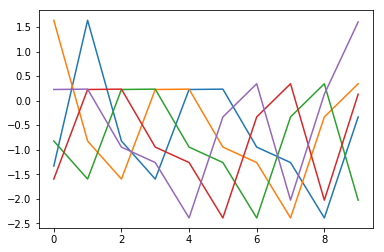

In [204]:
for window in test_windows[0:5]:
    plt.plot(window);

**Plot normal and anomalous sequences**

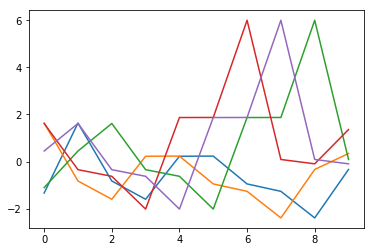

In [205]:
plt.plot(test_windows[0])
plt.plot(test_windows[1])
plt.plot(test_windows[outlier_indices[1]])
plt.plot(test_windows[outlier_indices[3]])
plt.plot(test_windows[20]);

**Need to expand dimensions [samples, sequence_length, features]**

91 samples of 10 sequence_length each and since each point is univariate so feature size = 1

In [206]:
x_test = np.expand_dims(np.array(test_windows), axis=2)
x_test.shape

(91, 10, 1)

In [207]:
hidden_dim = 16

In [208]:
m = Sequential()
m.add(LSTM(units=hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(rate=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')

In [209]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 16)            1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [210]:
history = m.fit(x_train, x_train, batch_size=64, epochs=5, validation_data=(x_test, x_test)).history

Train on 91 samples, validate on 91 samples
Epoch 1/5
91/91 [==============================] - 1s - loss: 0.8615 - val_loss: 1.3632
Epoch 2/5
91/91 [==============================] - 0s - loss: 0.8603 - val_loss: 1.3610
Epoch 3/5
91/91 [==============================] - 0s - loss: 0.8564 - val_loss: 1.3586
Epoch 4/5
91/91 [==============================] - 0s - loss: 0.8552 - val_loss: 1.3562
Epoch 5/5
91/91 [==============================] - 0s - loss: 0.8534 - val_loss: 1.3537


In [211]:
pred_x_test = m.predict(x_test)

In [212]:
pred_x_test.shape

(91, 10, 1)

In [213]:
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_of_predictions

array([  5.1028349 ,   5.11486843,   5.08296809,   5.09987257,
         5.17169728,   5.14352006,   5.10636055,   5.2216274 ,
         5.41067502,   3.93045798,   3.96070158,   3.89167585,
         3.19786251,   3.16737146,   2.94458409,   3.93642329,
         3.92711022,   3.91456741,  33.82172514,  33.83901131,
        33.79168164,  33.84339947,  34.01202606,  33.98883065,
        33.88948234,  33.34036149,  34.03821472,  34.74077468,
         4.93248661,   4.91808406,   4.91591631,   4.75059307,
         4.95207556,   4.81896948,   2.77842156,   2.79602807,
         2.77642435,   2.84014684,   2.87909277,   2.84084707,
         2.77638994,   2.65231071,   1.73839487,   1.63515309,
         1.6825844 ,   0.39356049,   0.54264831,   0.54377166,
         0.54131438,   0.54458824,   0.55806842,   0.56052168,
         0.58394645,   0.65545283,   2.72452144,   2.72801376,
         2.71283639,   2.70556172,   2.71080526,   2.69493438,
         2.70254906,   2.87843515,   2.87383007,   2.86

In [214]:
mae_of_predictions.shape

(91,)

In [215]:
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
mae_threshold

16.271854852102955

In [216]:
pred_outlier_indices = np.where(mae_of_predictions > mae_threshold)[0]
pred_outlier_indices

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

**Metrics**

In [217]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [218]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [219]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [220]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [221]:
precision = float(tp) / (tp + fp)

In [222]:
hit_rate = float(tp) / (tp + fn)

In [223]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [224]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0
